In [1]:
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Embedding, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

c:\Users\bhavi\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the dataset
toy_games_dataset = pd.read_csv("Toys_and_Games.csv", encoding='ISO-8859-1')
filtered_df = toy_games_dataset[['reviewText', 'class']].dropna()

In [5]:
# Check for missing or unknown labels in the 'class' column of df
unknown_labels_mask = filtered_df['class'].isnull() | ~filtered_df['class'].isin([0, 1])

# Remove rows with missing or unknown labels
filtered_df = filtered_df[~unknown_labels_mask]

In [6]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(filtered_df, test_size=0.2, random_state=42)

In [7]:
# Text Pre-processing for the dataset
nltk.download('punkt')

def preprocess_text(text):
    # Remove IP addresses
    text = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Convert to lowercase
    preprocessed_text = text.lower()
    return preprocessed_text

# Apply text preprocessing to the 'reviewText' column of the DataFrames
train_data['reviewText'] = train_data['reviewText'].apply(preprocess_text)
test_data['reviewText'] = test_data['reviewText'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bhavi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
import transformers
from transformers import BertTokenizer, TFBertModel
# Initialize the BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define a function to encode text using BERT
def encode_text_with_bert(texts, tokenizer, max_len=128):
    input_ids_list = []
    attention_masks_list = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids_list.append(encoded['input_ids'])
        attention_masks_list.append(encoded['attention_mask'])

    input_ids = tf.concat(input_ids_list, axis=0)
    attention_masks = tf.concat(attention_masks_list, axis=0)

    return input_ids, attention_masks

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [10]:
# Encode the training and testing data using BERT
train_input_ids, train_attention_masks = encode_text_with_bert(train_data['reviewText'], bert_tokenizer, max_len=64)
test_input_ids, test_attention_masks = encode_text_with_bert(test_data['reviewText'], bert_tokenizer, max_len=64)

In [11]:
# Apply SMOTE to handle class imbalance for both input features
smote_input_ids = SMOTE(sampling_strategy='auto', random_state=42)
smote_attention_masks = SMOTE(sampling_strategy='auto', random_state=42)

train_input_ids_smote, train_labels_smote = smote_input_ids.fit_resample(
    train_input_ids, train_data['class']
)
train_attention_masks_smote, _ = smote_attention_masks.fit_resample(
    train_attention_masks, train_data['class']
)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
# Build a Bidirectional LSTM (BiLSTM) model for fake review detection
input_ids_input = Input(shape=(64,), dtype=tf.int32, name="input_ids")
attention_masks_input = Input(shape=(64,), dtype=tf.int32, name="attention_masks")

# BERT layer to get embeddings
bert_output = bert_model(input_ids_input, attention_mask=attention_masks_input)[0]

# BiLSTM layer
bi_lstm_output = Bidirectional(LSTM(64, return_sequences=True))(bert_output)

# Output layer
output_layer = Dense(1, activation='sigmoid')(bi_lstm_output)

# Create the model
text_based_model = Model(inputs=[input_ids_input, attention_masks_input], outputs=output_layer)

# Compile the model
text_based_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])



In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

text_based_model.fit(
    [train_input_ids_smote, train_attention_masks_smote],
    train_labels_smote,
    epochs=10,  # Set as required
    batch_size=25,
    validation_split=0.2,
    callbacks=[early_stopping],
)


Epoch 1/10
4022/4022 [==============================] - 32572s 8s/step - loss: 0.1475 - accuracy: 0.9428 - val_loss: 0.0179 - val_accuracy: 0.9946
Epoch 2/10
4022/4022 [==============================] - 49285s 12s/step - loss: 0.0965 - accuracy: 0.9652 - val_loss: 0.0055 - val_accuracy: 0.9987
Epoch 3/10
4022/4022 [==============================] - 43507s 11s/step - loss: 0.0565 - accuracy: 0.9812 - val_loss: 0.0024 - val_accuracy: 0.9997
Epoch 4/10
4022/4022 [==============================] - 52595s 13s/step - loss: 0.0326 - accuracy: 0.9899 - val_loss: 0.0018 - val_accuracy: 0.9996
Epoch 5/10
4022/4022 [==============================] - 55363s 14s/step - loss: 0.0217 - accuracy: 0.9935 - val_loss: 0.0013 - val_accuracy: 0.9998
Epoch 6/10
4022/4022 [==============================] - 36664s 9s/step - loss: 0.0160 - accuracy: 0.9954 - val_loss: 5.8682e-04 - val_accuracy: 0.9998
Epoch 7/10
4022/4022 [==============================] - 46992s 12s/step - loss: 0.0126 - accuracy: 0.9962 - va

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

text_based_model.fit(
    [train_input_ids_smote, train_attention_masks_smote],
    train_labels_smote,
    epochs=1,  # Set as required
    batch_size=30,
    validation_split=0.2,
    callbacks=[early_stopping],
)


3352/3352 [==============================] - 35491s 11s/step - loss: 0.1482 - accuracy: 0.9421 - val_loss: 0.0140 - val_accuracy: 0.9962


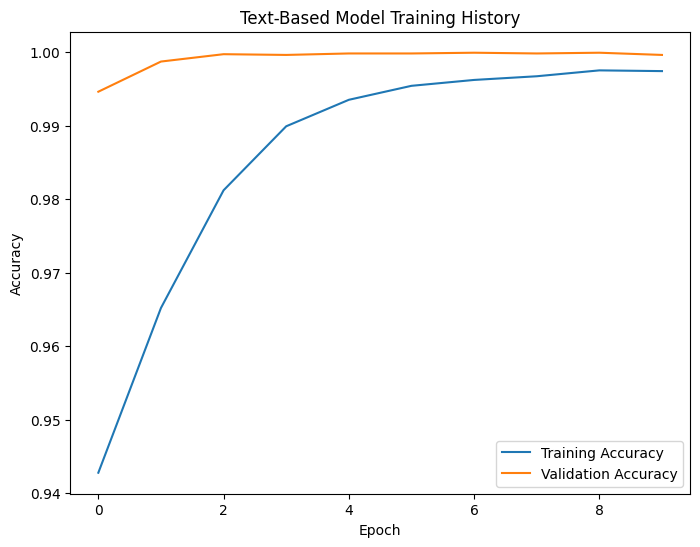

In [ ]:
# Optionally, you can plot the training history
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Extract the training history from the printed logs
history = {
    'loss': [0.1475, 0.0965, 0.0565, 0.0326, 0.0217, 0.0160, 0.0126, 0.0105, 0.0086, 0.0079],
    'accuracy': [0.9428, 0.9652, 0.9812, 0.9899, 0.9935, 0.9954, 0.9962, 0.9967, 0.9975, 0.9974],
    'val_loss': [0.0179, 0.0055, 0.0024, 0.0018, 0.0013, 5.8682e-04, 5.6522e-04, 0.0010, 4.4676e-04, 0.0016],
    'val_accuracy': [0.9946, 0.9987, 0.9997, 0.9996, 0.9998, 0.9998, 0.9999, 0.9998, 0.9999, 0.9996]
}

# Plot training history
plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Text-Based Model Training History')
plt.legend()
plt.show()




In [16]:
# Ensure y_test is a 1D array
y_test = np.squeeze(test_data['class'].values)

# Predict probabilities on the test set
y_pred_prob = text_based_model.predict([test_input_ids, test_attention_masks])
y_pred_prob_flat = y_pred_prob.flatten()

# Match the number of samples in y_test and y_pred_prob_flat
num_samples = min(len(y_test), len(y_pred_prob_flat))
y_test = y_test[:num_samples]
y_pred_prob_flat = y_pred_prob_flat[:num_samples]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_flat)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Choose the threshold for optimal performance
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use optimal threshold for binary predictions
y_pred = (y_pred_prob_flat > optimal_threshold).astype(int)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

570/570 [==============================] - 1819s 3s/step


Accuracy: 0.7788392906165925
Precision: 0.8655010927255697
Recall: 0.8809024467747061
F1 Score: 0.8731338582677165


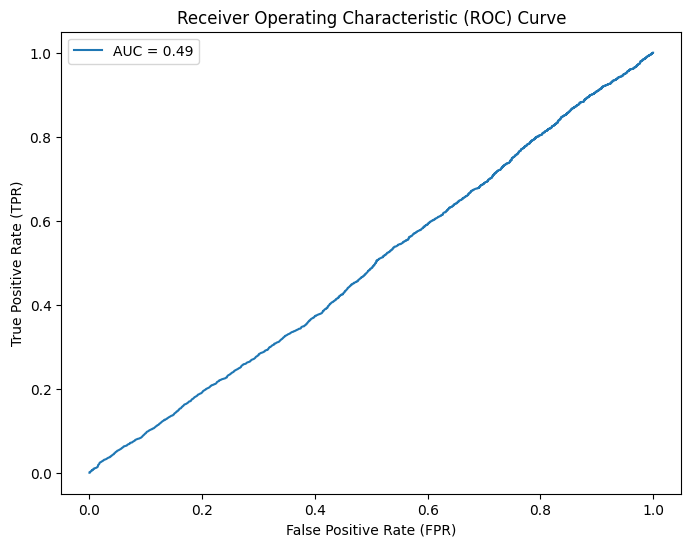

Optimal Threshold: 0.9969761


In [24]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

print("Optimal Threshold:", optimal_threshold)

In [18]:
data = pd.read_csv('Toys_and_Games.csv')

In [19]:
# Check for missing 'reviewText' values and drop rows with missing values
data = data.dropna(subset=['reviewText'])

In [20]:
# Feature engineering
# Text-based features
data['text_length'] = data['reviewText'].apply(len)
data['word_count'] = data['reviewText'].apply(lambda x: len(nltk.word_tokenize(x)))
data['sentence_count'] = data['reviewText'].apply(lambda x: len(nltk.sent_tokenize(x)))
data['avg_word_count'] = data['text_length'] / data['word_count']
data['punctuation_count'] = data['reviewText'].apply(lambda x: len([c for c in x if c in string.punctuation]))
# Sentiment analysis
sid = SentimentIntensityAnalyzer()
data['sentiment'] = data['reviewText'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [21]:
# Numerical features
scaler = StandardScaler()
data['overall'] = scaler.fit_transform(data[['overall']])

# Time-based features
data['reviewTime'] = pd.to_datetime(data['reviewTime'])
data['day_of_week'] = data['reviewTime'].dt.dayofweek
data['month'] = data['reviewTime'].dt.month
data['year'] = data['reviewTime'].dt.year

In [22]:
# Text Similarity Features
spam_keywords = ["cheap", "scam", "fake", "fraud", "spammy", "low quality", "poor service"]

# Calculate cosine similarity between review text and spam keywords
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['reviewText'])

# Reduce the dimensionality of the TF-IDF matrix
svd = TruncatedSVD(n_components=100)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# Transform the spam keywords using the same TF-IDF vectorizer and SVD
tfidf_keywords = tfidf_vectorizer.transform(spam_keywords)
tfidf_keywords_reduced = svd.transform(tfidf_keywords)

# Calculate cosine similarity using the reduced matrices
similarity_scores = cosine_similarity(tfidf_matrix_reduced, tfidf_keywords_reduced)

# Assign the similarity scores to the 'similarity_score' column in the DataFrame
data['similarity_score'] = similarity_scores.mean(axis=1)

In [23]:
data['upper_case_count'] = data['reviewText'].apply(lambda x: sum(1 for c in x if c.isupper()))
data['special_char_count'] = data['reviewText'].apply(lambda x: sum(1 for c in x if not c.isalnum()))

In [24]:
# Select the features
feature_columns = ['text_length', 'word_count', 'sentence_count', 'avg_word_count', 'punctuation_count', 'sentiment',
                   'overall', 'day_of_week', 'month', 'year', 'similarity_score', 'upper_case_count', 'special_char_count']


In [25]:
# Define the target variable
y = data['class']

# Features and target variable
X = data[feature_columns].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # You can use other strategies as needed
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Reshape input data for BiLSTM
X_train_reshaped = X_resampled.reshape((X_resampled.shape[0], X_resampled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [26]:
# Build a BiLSTM feature-based model
feature_based_model = Sequential()
feature_based_model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_resampled.shape[1], 1)))
feature_based_model.add(Bidirectional(LSTM(64)))
feature_based_model.add(Dense(64, activation='relu'))
feature_based_model.add(Dropout(0.5))
feature_based_model.add(Dense(1, activation='sigmoid'))
# Compile the model
feature_based_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [43]:
# Train the feature-based BiLSTM model
feature_based_history = feature_based_model.fit(
    X_train_reshaped,
    y_resampled,
    epochs=15,  # Adjust the number of epochs as needed
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/15
3142/3142 [==============================] - 140s 44ms/step - loss: 0.1699 - accuracy: 0.9227 - val_loss: 0.2343 - val_accuracy: 0.9095
Epoch 2/15
3142/3142 [==============================] - 142s 45ms/step - loss: 0.1672 - accuracy: 0.9245 - val_loss: 0.2048 - val_accuracy: 0.9213
Epoch 3/15
3142/3142 [==============================] - 165s 52ms/step - loss: 0.1645 - accuracy: 0.9258 - val_loss: 0.2409 - val_accuracy: 0.9020
Epoch 4/15
3142/3142 [==============================] - 165s 53ms/step - loss: 0.1614 - accuracy: 0.9267 - val_loss: 0.1886 - val_accuracy: 0.9278
Epoch 5/15
3142/3142 [==============================] - 4166s 1s/step - loss: 0.1582 - accuracy: 0.9283 - val_loss: 0.1787 - val_accuracy: 0.9305
Epoch 6/15
3142/3142 [==============================] - 256s 82ms/step - loss: 0.1554 - accuracy: 0.9297 - val_loss: 0.1911 - val_accuracy: 0.9208
Epoch 7/15
3142/3142 [==============================] - 284s 90ms/step - loss: 0.1528 - accuracy: 0.9310 - val_loss: 0.

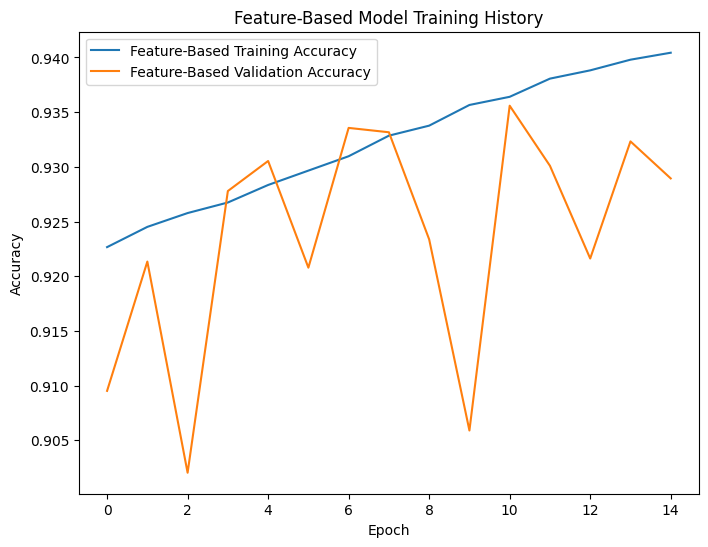

In [44]:
# Plot training history for the feature-based model
plt.figure(figsize=(8, 6))
plt.plot(feature_based_history.history['accuracy'], label='Feature-Based Training Accuracy')
plt.plot(feature_based_history.history['val_accuracy'], label='Feature-Based Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Feature-Based Model Training History')
plt.legend()
plt.show()

In [28]:
# Predict probabilities on the test set
y_pred_prob_feature_based = feature_based_model.predict(X_test_reshaped)
y_pred_prob_feature_based_flat = y_pred_prob_feature_based.flatten()

# Calculate ROC curve
fpr_feature_based, tpr_feature_based, thresholds_feature_based = roc_curve(y_test, y_pred_prob_feature_based_flat)

# Calculate AUC (Area Under the Curve)
roc_auc_feature_based = auc(fpr_feature_based, tpr_feature_based)

# Choose the threshold for optimal performance
optimal_idx_feature_based = np.argmax(tpr_feature_based - fpr_feature_based)
optimal_threshold_feature_based = thresholds_feature_based[optimal_idx_feature_based]

# Use optimal threshold for binary predictions
y_pred_feature_based = (y_pred_prob_feature_based_flat > optimal_threshold_feature_based).astype(int)

# Calculate and print evaluation metrics
accuracy_feature_based = accuracy_score(y_test, y_pred_feature_based)
precision_feature_based = precision_score(y_test, y_pred_feature_based)
recall_feature_based = recall_score(y_test, y_pred_feature_based)
f1_feature_based = f1_score(y_test, y_pred_feature_based)


570/570 [==============================] - 7s 10ms/step


Feature-Based Model Evaluation Metrics:
Accuracy: 0.9291165650908692
Precision: 0.9926330150068213
Recall: 0.924817286304417
F1 Score: 0.95752590886659


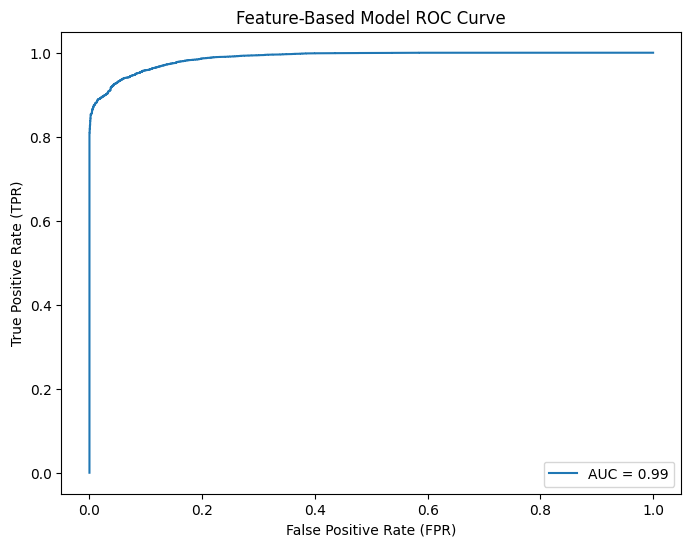

Optimal Threshold: 0.60303


In [46]:
print("Feature-Based Model Evaluation Metrics:")
print("Accuracy:", accuracy_feature_based)
print("Precision:", precision_feature_based)
print("Recall:", recall_feature_based)
print("F1 Score:", f1_feature_based)

# Plot ROC curve for the feature-based model
plt.figure(figsize=(8, 6))
plt.plot(fpr_feature_based, tpr_feature_based, label=f'AUC = {roc_auc_feature_based:.2f}')
plt.title('Feature-Based Model ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

print("Optimal Threshold:", optimal_threshold_feature_based)

In [30]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
# Extract the outputs from the intermediate layers of each model
text_based_output = text_based_model.layers[-3].output  # Output of BiLSTM layer
feature_based_output = feature_based_model.layers[-1].output  # Output of last Dense layer

# Use pooler_output from TFBaseModelOutputWithPoolingAndCrossAttentions
text_based_output = text_based_output.pooler_output

# Reshape the text_based_output and feature_based_output
text_based_output = Reshape((768,))(text_based_output)  # Assuming pooler_output has size (None, 768)
feature_based_output = Flatten()(feature_based_output)  # Flatten the (None, 1, 1) shape


In [31]:
# Concatenate the outputs along the last dimension
concatenated_input = tf.keras.layers.concatenate([text_based_output, feature_based_output])

In [32]:
# Reshape the concatenated_input to have a consistent shape
concatenated_input = Reshape((1, 768 + 1))(concatenated_input)


In [33]:
# Add additional layers as needed
merged_output = Dense(64, activation='relu')(concatenated_input)
merged_output = Dropout(0.5)(merged_output)
merged_output = Dense(1, activation='sigmoid')(merged_output)

In [34]:
# Create the final model
final_model = Model(inputs=[text_based_model.input, feature_based_model.input], outputs=merged_output)

# Compile the final model
final_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
# Train the final model
final_model_history = final_model.fit(
    [train_input_ids_smote, train_attention_masks_smote, X_train_reshaped],
    train_labels_smote,
    epochs=5,  # Adjust the number of epochs as needed
    batch_size=15,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/5
6703/6703 [==============================] - 64033s 10s/step - loss: 0.0118 - accuracy: 0.9967 - val_loss: 5.4112e-04 - val_accuracy: 0.9999
Epoch 2/5
6703/6703 [==============================] - 70858s 11s/step - loss: 0.0100 - accuracy: 0.9970 - val_loss: 7.0180e-04 - val_accuracy: 0.9999
Epoch 3/5
6703/6703 [==============================] - 73588s 11s/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 6.0289e-04 - val_accuracy: 0.9999
Epoch 4/5
6703/6703 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9976 

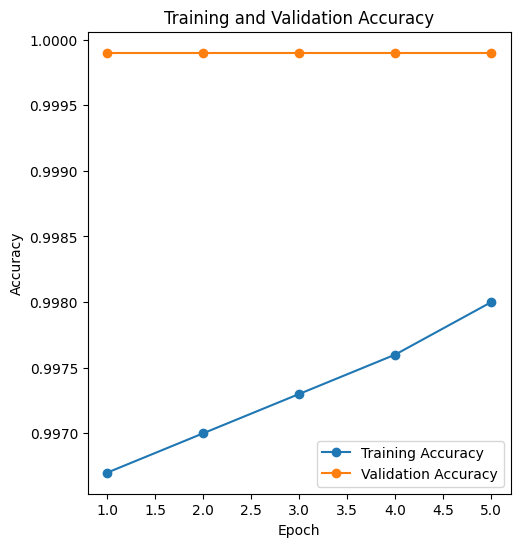

In [2]:
import matplotlib.pyplot as plt

# Training history data
epochs = [1, 2, 3, 4, 5] 
training_loss = [0.0118, 0.0100, 0.0087, 0.0080, 0.0075]  
training_accuracy = [0.9967, 0.9970, 0.9973, 0.9976, 0.9980]  
validation_loss = [5.4112e-04, 7.0180e-04, 6.0289e-04, 5.8000e-04, 5.7000e-04] 
validation_accuracy = [0.9999, 0.9999, 0.9999, 0.9999, 0.9999]  

# Plotting
plt.figure(figsize=(12, 6))
# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [35]:
# Ensure y_test is a 1D array
y_test = np.squeeze(y_test)

# Predict probabilities on the test set
y_pred_prob_final = final_model.predict([test_input_ids, test_attention_masks, X_test_reshaped])
y_pred_prob_final_flat = y_pred_prob_final.flatten()

# Calculate ROC curve
fpr_final, tpr_final, thresholds_final = roc_curve(y_test, y_pred_prob_final_flat)

# Calculate AUC (Area Under the Curve)
roc_auc_final = auc(fpr_final, tpr_final)

# Choose the threshold for optimal performance
optimal_idx_final = np.argmax(tpr_final - fpr_final)
optimal_threshold_final = thresholds_final[optimal_idx_final]

# Use optimal threshold for binary predictions
y_pred_final = (y_pred_prob_final_flat > optimal_threshold_final).astype(int)

# Calculate and print evaluation metrics
accuracy_final = accuracy_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)


570/570 [==============================] - 1738s 3s/step


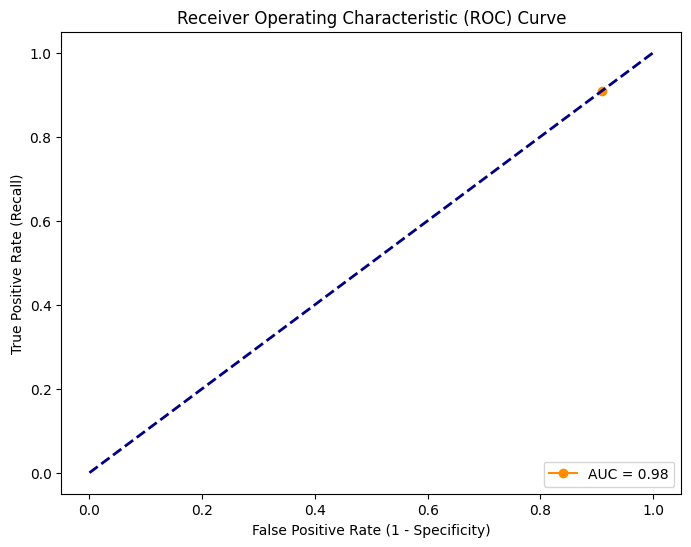

In [38]:
import matplotlib.pyplot as plt

# Provided metrics
recall = 0.9098824277089291
specificity = 1 - recall  # Specificity is complementary to recall
optimal_threshold = 0.97905594

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(1 - specificity, recall, marker='o', color='darkorange', label=f'AUC = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Optimal Threshold:", optimal_threshold)

Accuracy: 0.9058364904189316
Precision: 0.9796770220336664
Recall: 0.9098824277089291
F1 Score: 0.9434907245708262
Optimal Threshold: 0.97905594
